<a href="https://colab.research.google.com/github/stanbsky/int2_image_classifier/blob/main/kaggle94gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zx_cnqol because the default path (/run/user/141228/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import torchvision.datasets as datasets

In [3]:
from numba import cuda
cuda.select_device(6)

<weakproxy at 0x7f4bf61d8ae8 to Device at 0x7f4bf61d79e8>

In [4]:
stats= ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)) #mean and std
train_tfm= tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfm = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [5]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_tfm,
)

Files already downloaded and verified


In [6]:

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=valid_tfm,
)

Files already downloaded and verified


In [7]:
valid_ds = test_data
train_ds = training_data
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [8]:
img, label= train_ds[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 6


tensor([[[-0.7426, -0.4324, -0.1223,  ..., -1.4598, -1.2854, -0.4518],
         [-1.1303, -0.7232, -0.3549,  ..., -1.0527, -0.8007, -0.2967],
         [-0.5681, -0.5875, -0.3355,  ..., -0.5487, -0.2773, -0.0447],
         ...,
         [ 0.6725,  0.2267, -1.4598,  ...,  1.6030,  1.4673,  1.4091],
         [ 0.9245,  1.1765, -0.2192,  ...,  1.8356,  1.4673,  1.1765],
         [ 1.5642,  1.5061,  0.3430,  ...,  1.7581,  1.3122,  0.8276]],

        [[-1.2972, -1.1006, -0.8646,  ..., -1.7889, -1.7889, -1.1399],
         [-1.6512, -1.3562, -1.0809,  ..., -1.4742, -1.3759, -0.9826],
         [-1.1792, -1.2579, -1.0809,  ..., -1.0612, -0.9432, -0.7466],
         ...,
         [ 0.1974, -0.3532, -1.9463,  ...,  0.9251,  0.5908,  0.7481],
         [ 0.4138,  0.6301, -0.7072,  ...,  1.1611,  0.5318,  0.4924],
         [ 0.9841,  0.8661, -0.3139,  ...,  1.0038,  0.2564, -0.0189]],

        [[-1.6946, -1.5971, -1.4410,  ..., -1.8117, -2.0068, -1.5580],
         [-1.9287, -1.7531, -1.5580,  ..., -1

In [9]:
def show_image(img,label):
    print('Label: ', train_ds.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ship (8)


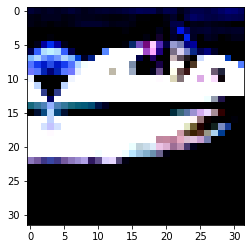

In [10]:
show_image(train_ds[222][0],train_ds[222][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  horse (7)


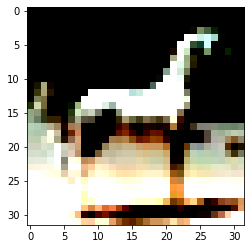

In [11]:
show_image(*train_ds[1543])

In [12]:
batch_size=400

In [13]:
# Dataloader to load data in batches(mini batch)
train_dl= DataLoader(train_ds,batch_size,shuffle=True, num_workers=2, pin_memory=True)
valid_dl= DataLoader(valid_ds, batch_size, num_workers=2,pin_memory=True)

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax= plt.subplots(figsize=(12,12))
        ax.set_xticks([]) #hide ticks
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
        break # printing only first 64 images from first batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


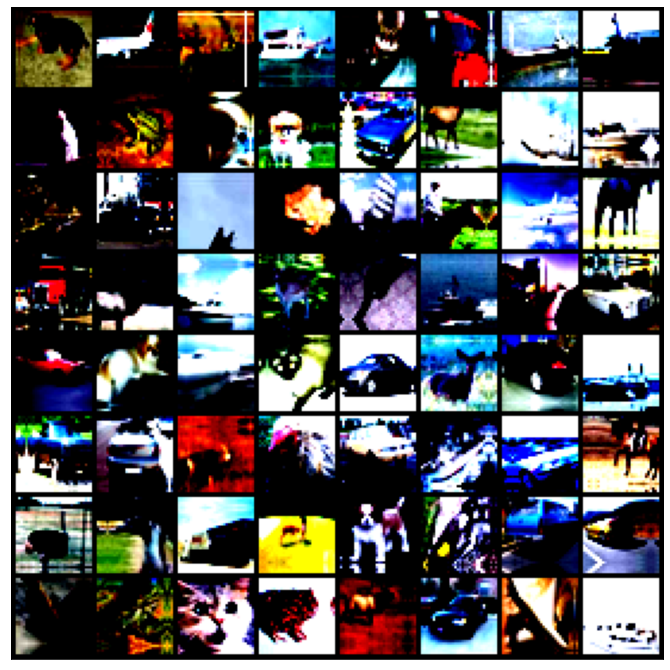

In [15]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


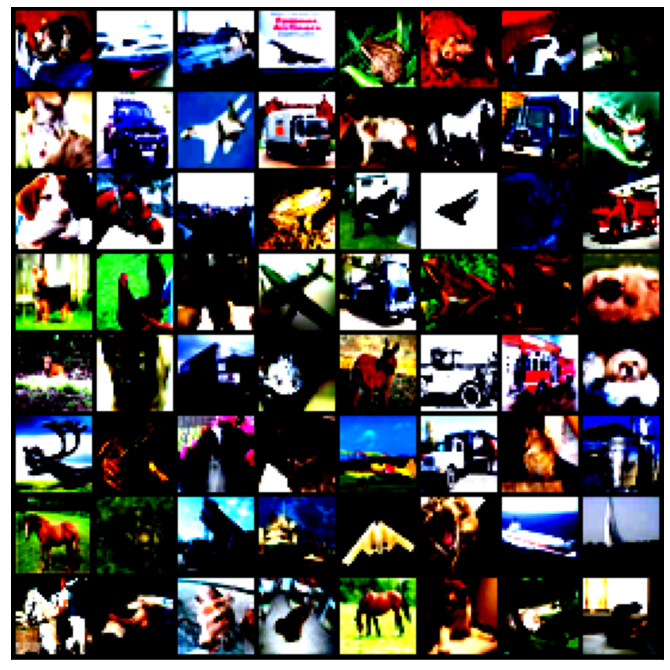

In [16]:
show_batch(valid_dl)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl= DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [22]:
model= to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Realsing cuda memory otherwise might get cuda out of memory error
    history = []
    
    #custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train() #Setting training mode
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3048949241638184, 'val_acc': 0.10000000149011612}]

In [25]:
epochs = 70
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.4656, val_loss: 1.1299, val_acc: 0.5921
Epoch [1], train_loss: 0.9501, val_loss: 0.9300, val_acc: 0.6713
Epoch [2], train_loss: 0.7421, val_loss: 0.8585, val_acc: 0.7174
Epoch [3], train_loss: 0.6379, val_loss: 0.7555, val_acc: 0.7425
Epoch [4], train_loss: 0.5728, val_loss: 0.8361, val_acc: 0.7253
Epoch [5], train_loss: 0.5246, val_loss: 0.7095, val_acc: 0.7665
Epoch [6], train_loss: 0.5147, val_loss: 0.5957, val_acc: 0.8017
Epoch [7], train_loss: 0.4590, val_loss: 0.4962, val_acc: 0.8294
Epoch [8], train_loss: 0.4695, val_loss: 0.7319, val_acc: 0.7651
Epoch [9], train_loss: 0.4290, val_loss: 0.5266, val_acc: 0.8307
Epoch [10], train_loss: 0.4635, val_loss: 0.8986, val_acc: 0.7221
Epoch [11], train_loss: 0.3992, val_loss: 0.9286, val_acc: 0.7095
Epoch [12], train_loss: 0.4313, val_loss: 0.8396, val_acc: 0.7498
Epoch [13], train_loss: 0.4185, val_loss: 0.6864, val_acc: 0.7785
Epoch [14], train_loss: 0.4110, val_loss: 0.6899, val_acc: 0.7774
Epoch [15], train_lo

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

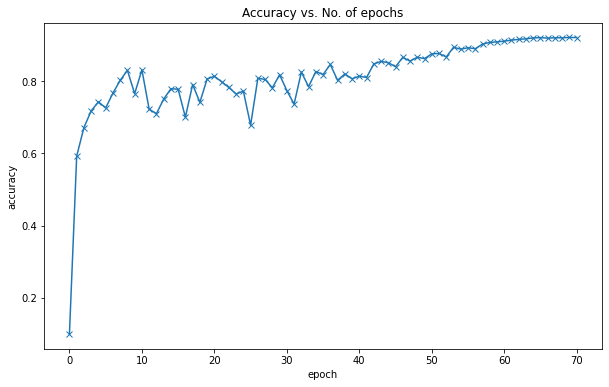

In [28]:
plot_accuracies(history)

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

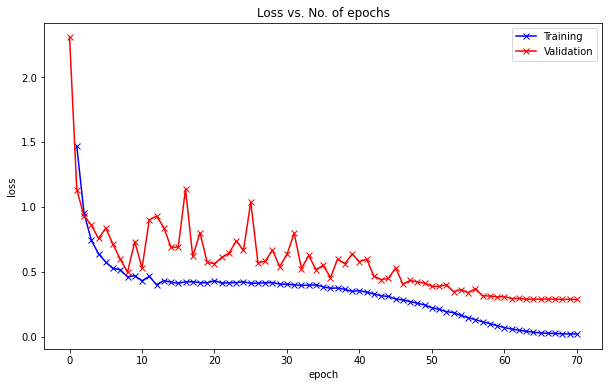

In [30]:
plot_losses(history)

In [31]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(10,6))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

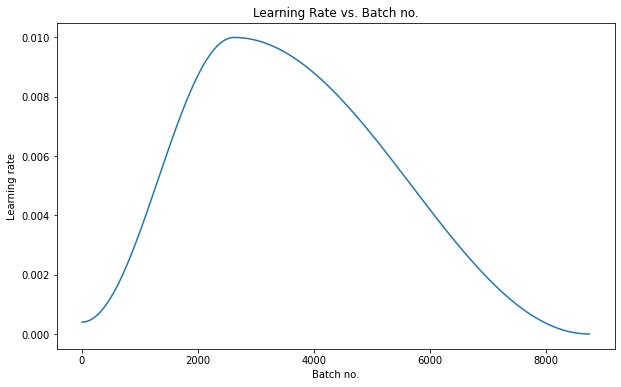

In [32]:
plot_lrs(history)